In [1]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
# import numba
from numba import njit
import h5py
import glob
from scipy.optimize import newton, curve_fit
from scipy.signal import find_peaks

/home/nkarthi/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Helper functions

In [2]:
def extract_data(h5_filepath, dims, begin = 0, end = 1, nVars = 38):
    if type(dims) == list:
        dims = np.array(dims)

    with h5py.File(h5_filepath,'r') as h5f:
        keys = list(h5f.keys())
        test = h5f[keys[-1]]
        keys = list(test.keys())
        
        # boxDims = test[keys[1]][()]
        # # print(boxDims)
        domain_decomp = test[keys[1]][()]
        data = test[keys[2]][()]
    
    output = np.zeros((end - begin, *dims))
    decomp_box_size = [int(domain_decomp[0][5]-domain_decomp[0][2]+1),
                       int(domain_decomp[0][4]-domain_decomp[0][1]+1),
                       int(domain_decomp[0][3]-domain_decomp[0][0]+1)]
    sz = 1
    for i in decomp_box_size: sz *= i
    revdims = np.flip(dims)

    for i in range(begin, end):
        currVar = np.zeros(revdims)
        for j in range(0, len(domain_decomp)):
            curr_decomp = domain_decomp[j]
            slc = np.s_[curr_decomp[2]:curr_decomp[5]+1, curr_decomp[1]:curr_decomp[4]+1, curr_decomp[0]:curr_decomp[3]+1]
            currVar[slc] = data[(i + j*nVars)*sz:(i+1 + j*nVars)*sz].reshape(*decomp_box_size)
    
        output[i - begin] = np.moveaxis(currVar, [0, -1], [-1, 0])

    return output

In [3]:
def lattice_fourier_laplacian(kx, ky, kz):
    expr1 = np.cos(kx) + np.cos(ky) + np.cos(kz)
    expr2 = np.cos(kx)*np.cos(ky) + np.cos(ky)*np.cos(kz) + np.cos(kx)*np.cos(kz)
    out = 2/9*expr1 + 2/9*expr2 - 4/3
    cs2 = 1/3
    return -out/cs2

def model_cs2(density, C0):
    return T

def cs2k(kx, ky, kz, density, C0):
    thermal_cs2 = model_cs2(density, C0)
    k2 = lattice_fourier_laplacian(kx, ky, kz)
    return thermal_cs2 + k2*kappa

# def mu_c(density, C0):
#     # return (-T*density*np.log((density - C0)/C0) - Lambda*(2.*C0 - density))/(2.*density)
#     return (-C0*chi*(C0 - density) - T*np.power(density, 2)/2)/(C0*density*(C0 - density))

def mu_c(rho0, phi0):
    return (-2.*T*np.power(rho0, 2) - chi*np.power(phi0, 2) + chi*np.power(rho0, 2))/(2.*rho0*(np.power(phi0, 2) - np.power(rho0, 2)))

def mu_ck(kx, ky, kz, density, C0):
    ref_state = mu_c(density, C0)
    k2 = lattice_fourier_laplacian(kx, ky, kz)
    if correlated:
        out = ref_state + kappa*k2
    else:
        out = ref_state
    return out

In [4]:
def spherically_averaged_structure_factor(data, density, C0, scale_factor = 1, func = None, shift = True, cs = True):
    L = min(data.shape)
    S = data.copy()

    if shift:
        freqs = fft.fftshift(fft.fftfreq(L))
    else:
        freqs = fft.fftfreq(L)
    if len(data.shape) == 3:
        kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
        k = np.stack([kx, ky, kz], axis = -1)
    elif len(data.shape) == 2:
        kx, ky = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L]]), indexing='ij')
        k = np.stack([kx, ky], axis = -1)
     
    k1 = np.linalg.norm(k, axis=-1).flatten()
    
    if func is not None:
        if cs:
            S = func(S, cs2k(kx, ky, kz, density, C0))
        else:
            S = func(S, mu_ck(kx, ky, kz, density, C0))
    S /= scale_factor

    # test[slc] /= test.sum()
    # S[L//2, L//2, L//2] /= S.sum()

    S1 = S.flatten()
    kmin = 2*np.pi/L # sampling frequency
    where = np.s_[:]#np.where(k1<=kmax)
    bins = np.arange(L//2+1)*kmin # kmax+1 for bin_edges: len(bins)=len(hist)+1
    
    shells = np.histogram(k1[where], bins, weights=S1[where])[0]
    counts = np.histogram(k1[where], bins)[0]
    return (bins[:-1]+bins[1:])/2, shells/counts

In [5]:
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return r, azimuth, elevation

def sph2cart(azimuth,elevation,r):
    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

def radial_equilibration(data, density, C0, radius = 1, scale_factor = 1, func = None, cs = True):
    S = data.copy()
    L = min(S.shape)
    freqs = fft.fftshift(fft.fftfreq(L))
    kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')

    r, t, p = cart2sph(kx, ky, kz)

    if func is not None:
        if cs:
            S = func(S, cs2k(kx, ky, kz, density, C0))
        else:
            S = func(S, mu_ck(kx, ky, kz, density, C0))
    S /= scale_factor
    # S[L//2, L//2, L//2] /= S.sum()
    
    idxs = np.isclose(r, radius, atol = 2*np.pi/L)
    t = t[idxs]
    p = p[idxs]
    out = S[idxs]

    return t, p, out

In [6]:
def make_bins(to_bin1, binsize, to_bin2 = None):
    bins = np.linspace(to_bin1.min(), to_bin1.max(), binsize)

    out1 = np.zeros(binsize)
    shell = np.digitize(to_bin1, bins = bins, right = True)
    np.add.at(out1, shell, to_bin1)
    unique, counts = np.unique(shell, return_counts=True)
    out1 = out1[unique]
    out1 /= counts

    if to_bin2 is None:
        return bins, out1
    else:
        out2 = np.zeros(binsize)
        np.add.at(out2, shell, to_bin2)
        unique, counts = np.unique(shell, return_counts=True)
        out2 = out2[unique]
        out2 /= counts
        return out1, out2

In [7]:
def fb(phi, l, T, rho = 1):
    return -(l/2)*(phi/rho) + (T/2)*np.log((1 + phi/rho)/(1 - phi/rho))

def interface_height(density, chi, T, kappa):
    phi0 = -newton(fb, x0 = (0.5), args = (chi, T))
    xi = np.sqrt((0.142*kappa)/((chi/2 - T)-0.31*T*(phi0**2)))
    # fit_func = lambda x, b, c: newton(fb, x0 = (0.5), args = (chi, T))*np.tanh(b*(x - c))
    fit_func = lambda x, b:phi0*np.tanh((x - b)/xi)
    
    nx, ny, nz = density.shape
    lo_min = nx//4
    hi_max = 3*(nx//4)
    xraw = np.arange(lo_min, hi_max, 1)

    test = density[lo_min:hi_max, :, :]
    # x = np.linspace(0, test.shape[0] - 1, test.shape[0])
    height_func = np.zeros(test.shape[1:])

    for y in range(test.shape[1]):
        for z in range(test.shape[2]):
            slc = test[:, y, z]
            popt, pcov = curve_fit(fit_func, xraw, slc, p0 = [nx//2])
            height_func[y, z] = popt[0]
    return height_func

# Validation

## Homogeneous system

In [ ]:
L = 32
binsize = 10
correlated = True

kappa = 0.01
kbt = 1e-7
u0 = 0
cs2 = 1/3
gamma = 1.0
chi = 0.4
T = 0.32
rho0 = 1.0
phi0 = 0.0

idx = -1
savedir = f"./k_{kappa}/"
# savedir = f"./"
slc = np.s_[L//2, L//2, L//2]

In [ ]:
ts = yt.load(savedir+"SF_plt_mag*")
ds = ts[idx]
ad = ds.all_data()

In [ ]:
ds.field_list

### Density

In [ ]:
freqs = fft.fftshift(fft.fftfreq(L))
kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
k2 = lattice_fourier_laplacian(kx, ky, kz)
experiment_muck = cs2k(kx, ky, kz, 1.0, 0.0)
data = [np.array(ad[('boxlib', 'struct_fact_density_density')]).reshape(L, L, L)]

test = data[0].copy()
# test[slc] = (test.sum() - test[slc])/(L**3)
# test[slc] *= kbt/(L**3*T)
test /= kbt

fig, axs = plt.subplots(1, 3, figsize = (9, 3))

ax = axs[0]
test *= (experiment_muck)
test[slc] /= test.sum()
im = ax.imshow(test[L//2, :, :])
plt.colorbar(im, ax = ax, shrink = 0.8)

ax = axs[1]
im = ax.imshow(test[:, L//2, :])
plt.colorbar(im, ax = ax, shrink = 0.8)

ax = axs[2]
im = ax.imshow(test[:, :, L//2])
plt.colorbar(im, ax = ax, shrink = 0.8)

fig.tight_layout()

In [ ]:
data = [np.array(ad[('boxlib', 'struct_fact_density_density')]).reshape(L, L, L)]
slc = np.s_[L//2, L//2, L//2]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\rho$"]

rho_scale = lambda a, c: a*c
scale_factor = 1
# scale_factor = cs2

for d in data:
        d /= kbt
        # d[slc] = (d.sum() - d[slc])/(L**3)
        d[slc] /= (L**3*T)/kbt
        x, y = spherically_averaged_structure_factor(d, rho0, phi0, scale_factor = scale_factor, func = rho_scale)
        x, y = make_bins(x, binsize, to_bin2 = y)
        ax.plot(x, y, 
                marker = markers[0], color = colors[0],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
ax.set_ylim([0.95, 1.05])
fig.tight_layout()
# fig.savefig("./equilibration_ratio.svg")

In [ ]:
sz = 4
fig, tax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1.5, 2.5]

t_angle = 0
p_angle = 0 
# binsize = 10

# rho_scale = None
# scale_factor = 1/cs2

for d in data:
    ax1 = tax
    ax2 = pax
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho0, phi0, radius = r, func=rho_scale, scale_factor = scale_factor)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)


    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

fig.tight_layout()

### C1

In [ ]:
freqs = fft.fftshift(fft.fftfreq(L))
kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
k2 = lattice_fourier_laplacian(kx, ky, kz)
experiment_muck = mu_ck(kx, ky, kz, 1.0, 0.0)
data = [np.array(ad[('boxlib', 'struct_fact_phi_phi')]).reshape(L, L, L)]

test = data[0].copy()
# test[slc] = (test.sum() - test[slc])/(L**3)

fig, axs = plt.subplots(1, 3, figsize = (9, 3))

ax = axs[0]
# test[slc] = (test.sum() - test[slc])/32**3
test *= (experiment_muck)
test /= kbt
im = ax.imshow(test[L//2, :, :])
plt.colorbar(im, ax = ax)

ax = axs[1]
im = ax.imshow(test[:, L//2, :])
plt.colorbar(im, ax = ax)

ax = axs[2]
im = ax.imshow(test[:, :, L//2])
plt.colorbar(im, ax = ax)

fig.tight_layout()

In [ ]:
data = [np.array(ad[('boxlib', 'struct_fact_phi_phi')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\phi$"]

rho_func = lambda a, c: a*c
scale_factor = 1

for d in data:
        d[slc] = (d.sum() - d[slc])/L**3
        d /= kbt
        x, y = spherically_averaged_structure_factor(d, rho0, phi0, scale_factor = scale_factor, func = rho_func, cs = False)
        x, y = make_bins(x, binsize, to_bin2 = y)
        y[0] = 1
        ax.plot(x, y, 
                marker = markers[0], color = colors[0],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \phi(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
# print(x, y)
ax.set_ylim([0.95, 1.05])

In [ ]:
y

In [ ]:
sz = 4
fig, tax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1.5, 2.5]

t_angle = 0
p_angle = 0 
# binsize = 10

# rho_scale = None
# scale_factor = 1/cs2

for d in data:
    ax1 = tax
    ax2 = pax
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho0, phi0, radius = r, func=rho_scale, scale_factor = scale_factor, cs = False)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)


    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | \phi(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | \phi(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

fig.tight_layout()

### Velocities

In [ ]:
data = [np.array(ad[('boxlib', 'struct_fact_ux_ux')]).reshape(L, L, L), 
        np.array(ad[('boxlib', 'struct_fact_uy_uy')]).reshape(L, L, L),
        np.array(ad[('boxlib', 'struct_fact_uz_uz')]).reshape(L, L, L)]

slc_s = [np.s_[L//2, :, :], np.s_[:, L//2, :], np.s_[:, :, L//2]]
labels = ['yz', 'xz', 'xy']
fig, axs = plt.subplots(3, 3, figsize = (9, 9))

for i in range(3):
    d = data[i]
    d[slc] = (d.sum() - d[slc])/(L**3)
    d /= kbt
    for j in range(3):
        ax = axs[i, j]
        im = ax.imshow(d[slc_s[j]], vmin = 0.8, vmax = 1.2)
        plt.colorbar(im, ax = ax, shrink = 0.8)
        ax.set_title(f"$S_{{u_{chr(120+i)}u_{chr(120+i)}}}$ {labels[j]}")

fig.tight_layout()

In [ ]:
data = [np.array(ad[('boxlib', 'struct_fact_ux_ux')]).reshape(L, L, L), 
        np.array(ad[('boxlib', 'struct_fact_uy_uy')]).reshape(L, L, L),
        np.array(ad[('boxlib', 'struct_fact_uz_uz')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$u_x$", r"$u_y$", r"$u_z$"]

for i, d in enumerate(data):
        # d[slc] *= L**3
        # d[slc] /= 3*kbt
        d[slc] = (d.sum() - d[slc])/(L**3)
        d /= kbt
        x, y = spherically_averaged_structure_factor(d, rho0, phi0, scale_factor = 1)
        x, y = make_bins(x, binsize, to_bin2 = y)

        ax.plot(x, y, 
                marker = markers[i], color = colors[i],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[i])
ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | u_{\alpha}(k) | ^2 \rangle }{\rho_{0}k_b T}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
ax.set_ylim([0.95, 1.05])

In [ ]:
sz = 4
fig, tax = plt.subplots(1, 3, figsize = (sz*3, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 3, figsize = (sz*3, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1, 1.5]

t_angle = 0
p_angle = 0 
# binsize = 10

for j, d in enumerate(data):
    ax1 = tax[j]
    ax2 = pax[j]
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho0, phi0, radius = r)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | j_{\alpha} | ^2 \rangle }{rho_0 k_B T}$", fontsize = 14)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | j_{\alpha} | ^2 \rangle }{rho_0 k_B T}$", fontsize = 14)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)

fig.tight_layout()

## Interfacial fluctuations

#### Convolutions of phi

In [126]:
def rearrange_k(dist):
    nx, ny, nz = dist.shape
    out = np.zeros_like(dist)

    slc1 = np.s_[0:nx//2, 0:ny//2, 0:nz//2]
    slc2 = np.s_[nx//2:nx, 0:ny//2, 0:nz//2]
    slc3 = np.s_[0:nx//2, ny//2:ny, 0:nz//2]
    slc4 = np.s_[nx//2:nx, ny//2:ny, 0:nz//2]

    slc5 = np.s_[0:nx//2, 0:ny//2, nz//2:nz]
    slc6 = np.s_[nx//2:nx, 0:ny//2, nz//2:nz]
    slc7 = np.s_[0:nx//2, ny//2:ny, nz//2:nz]
    slc8 = np.s_[nx//2:nx, ny//2:ny, nz//2:nz]
    
    out[slc1] = dist[slc8]
    out[slc2] = dist[slc7]
    out[slc3] = dist[slc6]
    out[slc4] = dist[slc5]
    out[slc5] = dist[slc4]
    out[slc6] = dist[slc3]
    out[slc7] = dist[slc2]
    out[slc8] = dist[slc1]

    return out

In [127]:
chi = 1.1
T = 0.5
kappa = 0.03
L = 16

In [ ]:
## PROFILE GENERATION ##
slc = np.s_[0, :, :]

def fb(phi, l, T, rho = 1):
    return -(l/2)*(phi/rho) + (T/2)*np.log((1 + phi/rho)/(1 - phi/rho))
phi0 = newton(fb, x0 = (0.6), args = (chi, T))
b = -(np.power(chi, 2.350)/(pow(kappa, 0.640)*np.power(T, 5.559)*489.435))
intLoc = (L - 1.)/2.

box = np.linspace(0, L - 1, L)
X, Y, Z = np.meshgrid(*[box, box, box])

profile = phi0*np.tanh(b*(X - intLoc))
## PROFILE GENERATION ##

## FFT generation ##
profile_k = np.fft.fftn(profile)

profile_k_bar = rearrange_k(profile_k)
# test += phi0
kx, ky, kz = np.meshgrid(*[np.fft.fftfreq(L) for i in range(3)])

kx_bar = rearrange_k(kx)*2*np.pi
ky_bar = rearrange_k(ky)*2*np.pi
kz_bar = rearrange_k(kz)*2*np.pi

slc_k = np.s_[L//2, :, :]
slc_k2 = np.s_[:, :, L//2]
## FFT generation ##

sz = 4
rows = 3
cols = 2
fig, axs = plt.subplots(rows, cols, figsize = (sz*cols, sz*rows))
axs = axs.flatten()

ax = axs[0]
im = ax.imshow(profile[slc])
plt.colorbar(im, ax = ax, shrink = 0.7)
ax.set_title("Original profile")
ax.set_ylabel("x")
ax.set_xlabel("z")

idxs = np.where(profile_k.real == 0)
# profile_k[idxs] += phi0
profile_ifft = np.fft.ifftn(profile_k)
ax = axs[1]
im = ax.imshow(profile_ifft.real[slc])
plt.colorbar(im, ax = ax, shrink = 0.7)
ax.set_title("After ifft")
ax.set_ylabel("x")
ax.set_xlabel("z")

ax = axs[2]
im = ax.pcolormesh(kz_bar[slc], kx_bar[slc_k], profile_k_bar[slc_k].real)
plt.colorbar(im, ax = ax, shrink = 0.7)
ax.set_title(f"Real component at ky = 0")
ax.set_ylabel("x")
ax.set_xlabel("z")

ax = axs[3]
im = ax.pcolormesh(kz_bar[slc_k], kx_bar[slc_k], profile_k_bar[slc_k].imag)
plt.colorbar(im, ax = ax, shrink = 0.7)
ax.set_title(f"Imaginary component at ky = 0")
ax.set_ylabel("x")
ax.set_xlabel("z")

ax = axs[4]
im = ax.pcolormesh(ky_bar[slc_k2], kx_bar[slc_k2], profile_k_bar[slc_k2].real)
plt.colorbar(im, ax = ax, shrink = 0.7)
ax.set_title(f"Real component at kz = 0")
ax.set_ylabel("x")
ax.set_xlabel("y")

ax = axs[5]
im = ax.pcolormesh(ky_bar[slc_k2], kx_bar[slc_k2], profile_k_bar[slc_k2].imag)
plt.colorbar(im, ax = ax, shrink = 0.7)
ax.set_title(f"Imaginary component at kz = 0")
ax.set_ylabel("x")
ax.set_xlabel("y")


fig.tight_layout
fig.tight_layout()

In [ ]:
# profile_k /= L**3
testk = profile_k*profile_k.conj()
testk /= L**3

fig, axs = plt.subplots(1, 2, figsize = (8, 4))

ax = axs[0]
im = ax.imshow(testk[slc].real)
plt.colorbar(im, ax = ax)

# testk /= L**3
# testk += profile
test = np.fft.ifftn(testk)
ax = axs[1]
im = ax.imshow(test[slc].real)
plt.colorbar(im, ax = ax)

fig.tight_layout()

In [156]:
# from scipy.signal import convolve

# k2 = lattice_fourier_laplacian(kx, ky, kz)
# convolved = convolve(np.abs(testk), k2, mode = "same")

# plt.imshow(convolved[0])
# plt.colorbar()

In [ ]:
# test_profk = profile_k/np.sqrt(L**3)
# conj_test_profk = test_profk*test_profk.conj()
testk[0, :(L//2+1), 0].real

#### Investigating where the free energy remains bounded

In [ ]:
def fb(phi, l, T, rho = 1):
    return -(l/2)*(phi/rho) + (T/2)*np.log((1 + phi/rho)/(1 - phi/rho))

x = np.linspace(-1, 1, 1001)
l = 1.1
T = 0.50

y = fb(x, l, T)

plt.plot(x, y)
plt.plot([x[0], x[-1]], [0, 0], 'r')

newton(fb, x0 = (0.6), args = (l, T))

In [ ]:
# %%capture
@njit
def func_mu_rho(rho0, phi0, T, chi, k2, kappa):
    numerator = (-2.*T*np.power(rho0, 4) - chi*np.power(phi0, 4) + chi*np.power(phi0*rho0, 2))
    denominator = (2.*np.power(rho0, 3)*(np.power(phi0, 2) - np.power(rho0, 2)))
    out = numerator/denominator + k2*kappa
    return out

@njit 
def func_mu_phi(rho0, phi0, T, chi, k2, kappa):
    numerator = (-2.*T*np.power(rho0, 2) - chi*np.power(phi0, 2) + chi*np.power(rho0, 2))
    denominator = (2.*rho0*(np.power(phi0, 2) - np.power(rho0, 2)))
    # print(numerator, denominator)
    out = numerator/denominator + k2*kappa
    return out

L = 16
freqs = fft.fftshift(fft.fftfreq(L))
kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
k2 = lattice_fourier_laplacian(kx, ky, kz)

k2 = np.unique(np.round(k2, 1))
phi_s = np.linspace(-0.90, 0.90, k2.size)
rho_s = np.linspace(0.995, 1.005, k2.size)

kappa_set = 0.03
chi_set = 1.1
T_set = 0.5

K2, PHIS = np.meshgrid(*[k2, phi_s])
MUPHI = np.zeros_like(K2)
K2, RHOS = np.meshgrid(*[k2, rho_s])
MURHO = np.zeros_like(K2)

for i in range(k2.size):
    for j in range(k2.size):
        MUPHI[i,j] = func_mu_phi(1, PHIS[i, j], T_set, chi_set, K2[i, j], kappa_set)
        MURHO[i,j] = func_mu_rho(1, RHOS[i, j], T_set, chi_set, K2[i, j], kappa_set)

fig, axs = plt.subplots(1, 2, figsize = (8, 4))

ax = axs[0]
im = ax.pcolor(K2,PHIS,MUPHI, vmin = -0.01, vmax = 0.01)
plt.colorbar(im, ax = ax, label = r"$\mu_{\phi}$", orientation = 'horizontal')
ax.set_xlabel("k2")
ax.set_ylabel(r"$\phi$")

ax.set_title(f"T = {T_set}, $\chi$ = {chi_set}")
fig.tight_layout()

ax = axs[1]
im = ax.pcolor(K2,RHOS,MURHO, vmin = -0.01, vmax = 0.01)
plt.colorbar(im, ax = ax, label = r"$\mu_{\rho}$", orientation = 'horizontal')
ax.set_xlabel("k2")
ax.set_ylabel(r"$\rho$")

ax.set_title(f"T = {T_set}, $\chi$ = {chi_set}")
fig.tight_layout()

#### Calculating the general interface profile empirically

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (9, 3))

kappa_s = [0.01, 0.02, 0.03]
b_k = [-2.312, -1.5426, -1.1367]

chi_s = [1.1, 1.2, 1.3]
b_chi = [-2.312, -3.0679, -3.4158]

T_s = [0.48, 0.5, 0.52]
b_T = [-2.6976, -2.314, -1.7270]

ax = axs[0]
x = np.array(kappa_s)
y = np.array(b_k)
x = np.log(x)
y = np.log(np.abs(y))

ax.plot(x, y, 'bx--', label = "raw")

fit_func = lambda x, b, c: b*x + c
popt, pcov = curve_fit(fit_func, x, y)
print(popt)

xfit = np.linspace(x.min(), x.max(), 101)
yfit = fit_func(xfit, *popt)
ax.plot(xfit, yfit, 'r-', label = "fit")

ax.legend()
ax.set_xlabel(r"$\kappa$")
ax.set_ylabel(r"$b$")

ax = axs[1]
x = np.array(chi_s)
y = np.array(b_chi)
x = np.log(x)
y = np.log(np.abs(y))

ax.plot(x, y, 'bx--', label = "raw")

fit_func = lambda x, b, c: b*x + c
popt, pcov = curve_fit(fit_func, x, y)
print(popt)

xfit = np.linspace(x.min(), x.max(), 101)
yfit = fit_func(xfit, *popt)
ax.plot(xfit, yfit, 'r-', label = "fit")

ax.legend()
ax.set_xlabel(r"$\chi$")
ax.set_ylabel(r"$b$")

ax = axs[2]
x = np.array(T_s)
y = np.array(b_T)
x = np.log(x)
y = np.log(np.abs(y))

ax.plot(x, y, 'bx--', label = "raw")

fit_func = lambda x, b, c: b*x + c
popt, pcov = curve_fit(fit_func, x, y)
print(popt)

xfit = np.linspace(x.min(), x.max(), 101)
yfit = fit_func(xfit, *popt)
ax.plot(xfit, yfit, 'r-', label = "fit")

ax.legend()
ax.set_xlabel(r"$T$")
ax.set_ylabel(r"$b$")

fig.tight_layout()

We will also try to calculate the theoretical interfacial profile from the underlying math. The total free energy is defined as 

$$F(\rho, \phi, T, \chi) = f_0(\rho, \phi, T, \chi) + \frac{\kappa}{2}(\nabla \rho)^2 + \frac{\kappa}{2}(\nabla \phi)^2$$

Where $\rho$ and $\phi$ represent the sum and difference of the concentrations of fluids at each site, $T$ is the temperature of the system and $\chi$ is the thermodynamic parameter of the system. 

$$f_0(\rho, \phi, T, \chi) = \frac{\chi}{4}\rho(1 - (\frac{\phi}{\rho})^2) - \rho T + \frac{T}{2}(\rho + \phi)\ln{\frac{\rho + \phi}{2}} + \frac{T}{2}(\rho - \phi)\ln{\frac{\rho - \phi}{2}}$$

To obtain the interfacial profile, the chemical potential of $\phi$ will be used, defined as

$$\mu_{\phi} = -\frac{\chi}{2}\frac{\phi}{\rho} + \frac{T}{2}\ln{\frac{ 1 + \frac{\phi}{\rho} }{1 - \frac{\phi}{\rho}}} - \kappa \nabla^2 \phi$$

We will assume that $\rho = 1$, simplifying the above to

$$\mu_{\phi} = -\frac{\chi}{2}\phi + \frac{T}{2}\ln{\frac{ 1 + \phi }{1 - \phi}} - \kappa \nabla^2 \phi$$

To obtain the profile of the interface, we will assume that the system is at thermodynamic equilibrium, meaning that $\mu_{\phi} = 0$. We now have a non-linear ODE due to the $\phi$ terms in the $\ln$ term. We can then split the $\ln$ into two terms, then taylor expand the terms.

\begin{equation}
\ln(1 + \phi) =  \phi - \frac{\phi^2}{2} + \frac{\phi^3}{3} + O(x^4)
\end{equation}

\begin{equation}
\ln(1 - \phi) = -\phi - \frac{\phi^2}{2} - \frac{\phi^3}{3} + O(x^4)
\end{equation}

\begin{equation}
\ln(1 + \phi) - \ln(1 - \phi) = 2\phi + \frac{2\phi^3}{3}
\end{equation}

After the taylor expansion and $\ln$ term substitution, we get

$$\mu_{\phi} = -\frac{\chi}{2}\phi + T\phi + T\frac{\phi^3}{3} - \kappa \nabla^2 \phi$$

We assume that the interface profile has a profile defined as $\phi = \phi_0 \tanh{\frac{x}{\xi}}$. After substitution and simplification to solve for the value of $\xi$, we identify that the profile can be defined with the expression,

$$\phi = \phi_0 \tanh{\frac{x}{\xi}}$$

$$\xi = \sqrt{\frac{0.142\kappa}{(\frac{\chi}{2} - T) - 0.31T\phi_0^2}}$$

The value of $\phi_0$ is defined as the positive root of the bulk free energy, solved using the newton raphson numerical method. With this expression, an analytical solution for the surface tension can also be found by integrating the excess free energy from $-\infty$ to $\infty$

$$\sigma = \int_{\infty}^{\infty} \frac{\kappa}{2}(\nabla \phi)^2$$

After substituting the expression for $\phi$ and using sympy and wolfram alpha to evaulate the integral, the final analytical expression for the surface tension is found to be

$$\sigma = 2 \phi_0^2[1.76(\chi - 2T) - 1.092T\phi_0^2]$$

In [ ]:
import sympy as sp 

x = sp.symbols('x')
a = sp.symbols('alpha')
Cm = (sp.Rational(1) + sp.tanh(x/(2*a)))/sp.Rational(2)
dCm = sp.Derivative(Cm, x, 1).doit()

F = (Cm**2)*(1 - Cm)**2 + (a**2)*(dCm**2)

sp.integrate(F, x)

In [111]:
chi, T, phi, phi0, kappa, x = sp.symbols("chi, T, phi, phi0, kappa, x")

# b = (chi**2.356)*(T**5.559)/(kappa**0.640)
b = sp.sqrt(kappa*(chi/2 - T)/T)
phi = phi0*sp.tanh(b*x)
dphi = sp.Derivative(phi, x, 1).doit()

f0 = chi/4*(1 - phi**2) - T + T/2*(1 + phi)*sp.ln((1 + phi)/2) + T/2*(1 - phi)*sp.ln((1 - phi)/2)

expr = sp.integrate(kappa/2*(dphi**2), x).simplify()
# F = 

In [ ]:
chi = 1.1
T = 0.5
kappa = 0.03

def fb(phi, l, T, rho = 1):
    return -(l/2)*(phi/rho) + (T/2)*np.log((1 + phi/rho)/(1 - phi/rho))
phi0 = newton(fb, x0 = (0.55), args = (chi, T))

phi_theory = np.sqrt(3*(chi/2 - T)/T)
print(f"phi_real:{phi0:.3f} phi_theory:{phi_theory:.3f} Ratio:{phi_theory/phi0:.3f}")

In [ ]:
L = 5

x = np.linspace(-L, L, 2*L + 1)

b_model = (np.power(chi, 2.350)/(pow(kappa, 0.640)*np.power(T, 5.559)*489.435))
profile = phi0*np.tanh(b_model*x)
plt.plot(x, profile, "ro", label = "old fit", markerfacecolor = "None")

xi = np.sqrt((0.142*kappa)/((chi/2 - T)-0.31*T*(phi0**2)))
y = phi0*np.tanh(x/xi)

plt.plot(x, y, 'bs', label = "new fit", markerfacecolor = "None")
plt.legend()

In [51]:
import sympy as sp 

phi0, chi, kappa, T, x = sp.symbols("phi_0 chi kappa T x")

# xi = sp.sqrt((sp.Rational(0.142)*kappa)/((chi/2 - T) - sp.Rational(0.31)*T*(phi0**2)))
xi = sp.sqrt((0.142*kappa)/((chi/2 - T) - 0.31*T*(phi0**2)))
xi = xi.simplify()
phi = phi0*sp.tanh(x/xi)
dphi = sp.Derivative(phi, x, 1).doit().simplify()

excess_energy = kappa/2*(dphi**2)
bulk_energy = chi/4*(1 - phi**2) - T + T/2*(1+phi)*sp.ln((1+phi)/2) + T/2*(1-phi)*sp.ln((1-phi)/2)

total_energy = excess_energy + bulk_energy

c = 1.1
temp = 0.5
k = 0.03
# total_energy = total_energy.subs({chi:c, kappa:k, T:temp, phi0:newton(fb, x0 = (0.55), args = (c, temp))}).simplify()

unsub_expr = sp.integrate(excess_energy, (x, -sp.oo, sp.oo)).simplify()

excess_energy = excess_energy.subs({chi:c, kappa:k, T:temp, phi0:newton(fb, x0 = (0.55), args = (c, temp))}).simplify()
sub_expr = sp.integrate(excess_energy, (x, -sp.oo, sp.oo)).simplify()

In [ ]:
unsub_expr#.subs({chi:c, kappa:k, T:temp, phi0:newton(fb, x0 = (0.55), args = (c, temp))}).simplify()

#### Finite size effects in the fluctuations of the interface height

In [ ]:
import scipy.stats as stats

# fig, axs = plt.subplots(1, 2, figsize = (9, 3))
f, (ax1, ax2) = plt.subplots(1, 2,  figsize = (10, 5), gridspec_kw={'width_ratios': [3, 2]})
# color = [""]
chi = 1.1
T = 0.5
z = 64
h = np.zeros(z)
ls = []
paths = sorted(glob.glob(f"./2D_int/L_{z}/*.h5"))[-2:]
for path in paths:
    phi = extract_data(path, [16, 6, z], begin = 1, end = 2, nVars = 38)
    temph = interface_height(phi[0], chi, T)
    h += np.mean(temph, axis = 0)
    ls += list(temph)
h = h/len(paths)
x = np.linspace(0, z - 1, z)
ax1.plot(x/x.max(), h - h.mean(), label = f"z = {z}")
ls = np.array(ls)
ls -= ls.mean()
ax2.hist(ls.flatten(), density = True, label = f"z = {z}", alpha = 0.5, bins = 20)
# mu = 0
# sigma = np.std(h)
# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# ax2.plot(x, stats.norm.pdf(x, mu, sigma), label = f"z = {z}")

z = 128
h = np.zeros(z)
ls = []
paths = sorted(glob.glob(f"./2D_int/L_{z}/*.h5"))[-2:]
for path in paths:
    phi = extract_data(path, [16, 6, z], begin = 1, end = 2, nVars = 38)
    temph = interface_height(phi[0], chi, T)
    h += np.mean(temph, axis = 0)
    ls += list(temph)
h = h/len(paths)
x = np.linspace(0, z - 1, z)
ax1.plot(x/x.max(), h - h.mean(), label = f"z = {z}")
ls = np.array(ls)
ls -= ls.mean()
ax2.hist(ls.flatten(), density = True, label = f"z = {z}", alpha = 0.5, bins = 20)

z = 256
h = np.zeros(z)
ls = []
paths = sorted(glob.glob(f"./2D_int/L_{z}/*.h5"))[-2:]
for path in paths:
    phi = extract_data(path, [16, 6, z], begin = 1, end = 2, nVars = 38)
    temph = interface_height(phi[0], chi, T)
    h += np.mean(temph, axis = 0)
    ls += list(temph)
h = h/len(paths)
x = np.linspace(0, z - 1, z)
ax1.plot(x/x.max(), h - h.mean(), label = f"z = {z}")
ls = np.array(ls)
ls -= ls.mean()
ax2.hist(ls.flatten(), density = True, label = f"z = {z}", alpha = 0.5, bins = 20)

z = 512
h = np.zeros(z)
ls = []
paths = sorted(glob.glob(f"./2D_int/L_{z}/*.h5"))[-2:]
for path in paths:
    phi = extract_data(path, [16, 6, z], begin = 1, end = 2, nVars = 38)
    temph = interface_height(phi[0], chi, T)
    h += np.mean(temph, axis = 0)
    ls += list(temph)
h = h/len(paths)
x = np.linspace(0, z - 1, z)
ax1.plot(x/x.max(), h - h.mean(), label = f"z = {z}")
ls = np.array(ls)
ls -= ls.mean()
ax2.hist(ls.flatten(), density = True, label = f"z = {z}", alpha = 0.5, bins = 20)

ax1.legend(ncols = 2)
ax2.legend()
fig.tight_layout()

#### Calculations

In [49]:
nx = 20
ny = 2
nz = 800

boxDim = np.array([nx, ny, nz])

kappa = 0.03
kbt = 1e-7
u0 = 0
cs2 = 1/3
gamma = 1.0


chi = 1.1
T = 0.50

idx = -1
# savedir = f"./2D_int/L_{nz}/"
# savedir = f"./interface/L_{nz}/"
savedir = f"./"

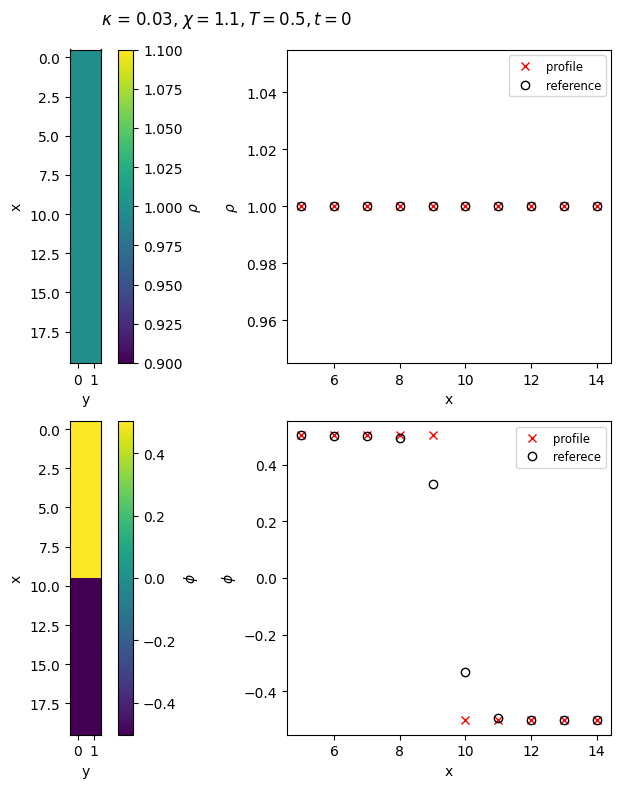

In [50]:
boxDim = np.array([nx, ny, nz])

# profile = extract_data(savedir + sorted(glob.glob("./*.h5"))[-1], [nx, ny, nz], begin = 1, end = 2, nVars = 38)
path = sorted(glob.glob(f"{savedir}/*.h5"))[idx]
profile = extract_data(path, boxDim, begin = 0, end = 2, nVars = 38)

# fit_func = lambda x, b, c: newton(fb, x0 = (0.6), args = (chi, T))*np.tanh(b*(x - c))

phi0 = -newton(fb, x0 = (0.5), args = (chi, T))
xi = np.sqrt((0.142*kappa)/((chi/2 - T)-0.31*T*(phi0**2)))
# fit_func = lambda x, b, c: newton(fb, x0 = (0.5), args = (chi, T))*np.tanh(b*(x - c))
fit_func = lambda x, b:phi0*np.tanh((x - b)/xi)

fig, axs = plt.subplots(2, 2, figsize = (8, 8))
axs = axs.flatten()

ax = axs[0]
im = ax.imshow(profile[0, :, : , nz//2])
ax.set_xlabel("y")
ax.set_ylabel("x")
plt.colorbar(im, ax = ax, label = r"$\rho$")

ax = axs[1]
x = np.arange(nx//4, 3*nx//4, 1)
im = ax.plot(x, profile[0, nx//4:3*nx//4, ny//2 , nz//2], 'rx', label = "profile")
ax.plot(x, np.ones(x.size), 'ko', label = "reference", markerfacecolor="None")

ax.set_xlabel("x")
ax.set_ylabel(r"$\rho$")
ax.legend(ncol = 1, fontsize = 'small')

ax = axs[2]
im = ax.imshow(profile[1, :, : , nz//2])
ax.set_xlabel("y")
ax.set_ylabel("x")
plt.colorbar(im, ax = ax, label = r"$\phi$")

ax = axs[3]
x = np.arange(nx//4, 3*nx//4, 1)
im = ax.plot(x, profile[1, nx//4:3*nx//4, ny//2 , nz//2], 'rx', label = "profile")

# x = np.linspace(0, nx - 1, nx)
# b = -(chi**2.350)/(kappa**0.640 * T**5.559*489.435)
# y = newton(fb, x0 = (0.6), args = (chi, T))*np.tanh(b*(x - (nx - 1)/2))
y = fit_func(x, (nx - 1)/2)
ax.plot(x, y, 'ko', label = "referece", markerfacecolor="None")

ax.set_xlabel("x")
ax.set_ylabel(r"$\phi$")
ax.legend(ncol = 1, fontsize = 'small')

t = int(path.split("/")[-1].split(".")[0].split("_")[-1])
fig.suptitle(f"$\kappa$ = {kappa}, $\chi = {chi}, T = {T}, t = {t}$")
fig.tight_layout()

In [120]:
heights_k = np.zeros((nz), dtype = np.complex128)

h5_paths = sorted(glob.glob(f"{savedir}/*.h5"))[1:]

for path in h5_paths:
    phi = extract_data(path, boxDim, begin = 1, end = 2, nVars = 38)
    h = interface_height(phi[0, :, :, :], chi, T, kappa)
    
    h = np.mean(h, axis = 0)
    h -= (nx - 1)//2
    # h_k = fft.fft(h, norm = 'backward')
    h_k = fft.fft(h, norm = 'ortho')
    # h_k = np.mean(h_k, axis = 0)

    heights_k += h_k*h_k.conjugate()
    t = int(path.split("/")[-1].split(".")[0].split("_")[-1])
    print(f"Timestep {t} processed")

heights_k = np.abs(heights_k)
heights_k /= len(h5_paths)
# heights_k /= nx*ny*nz

Timestep 90000 processed
Timestep 90100 processed
Timestep 90200 processed
Timestep 90300 processed
Timestep 90400 processed
Timestep 90500 processed
Timestep 90600 processed
Timestep 90700 processed
Timestep 90800 processed
Timestep 90900 processed
Timestep 91000 processed
Timestep 91100 processed
Timestep 91200 processed
Timestep 91300 processed
Timestep 91400 processed
Timestep 91500 processed
Timestep 91600 processed
Timestep 91700 processed
Timestep 91800 processed
Timestep 91900 processed
Timestep 92000 processed
Timestep 92100 processed
Timestep 92200 processed
Timestep 92300 processed
Timestep 92400 processed
Timestep 92500 processed
Timestep 92600 processed
Timestep 92700 processed
Timestep 92800 processed
Timestep 92900 processed
Timestep 93000 processed
Timestep 93100 processed
Timestep 93200 processed
Timestep 93300 processed
Timestep 93400 processed
Timestep 93500 processed
Timestep 93600 processed
Timestep 93700 processed
Timestep 93800 processed
Timestep 93900 processed


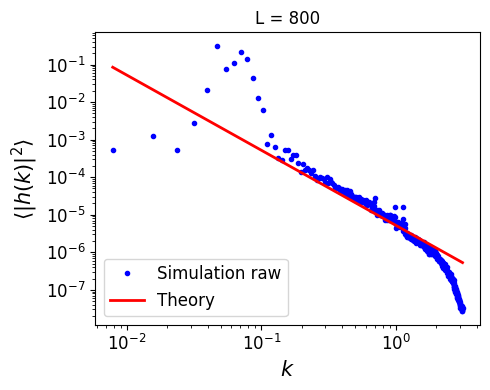

In [121]:
## EXPERIMENTAL RESULTS ##
L = nz
k1 = fft.fftfreq(L)*2*np.pi
S1 = heights_k.copy()

slc = slice(1, L//2)
xraw = k1[slc]
yraw = S1[slc]

binsize = 64
kmin = 2*np.pi/binsize
bins = np.arange(binsize//2+1)*kmin # kmax+1 for bin_edges: len(bins)=len(hist)+1
shells = np.histogram(k1[slc], bins, weights=S1[slc])[0]
counts = np.histogram(k1[slc], bins)[0]

xbin = (bins[:-1]+bins[1:])/2
ybin = shells/counts
## EXPERIMENTAL RESULTS ##

## THEORETICAL RESULTS ##
phi0 = newton(fb, x0 = (0.5), args = (chi, T))
sigma = 2*(phi0**2)*(1.76*(chi - 2*T) - 1.092*T*(phi0**2))

freqs_theory = np.linspace(xraw[0], xraw[-1], 1001)
interface_fluct_theory = kbt/(sigma*np.power(freqs_theory, 2))
## THEORETICAL RESULTS ##

sz = 4
ar = 1.25
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

ax.loglog(xraw, yraw, "bo", label = "Simulation raw", ms = 3)
# ax.loglog(xbin, ybin, "gx", label = "Simulation binned", ms = 3)
ax.loglog(freqs_theory, interface_fluct_theory, 'r-', lw = 2, label = "Theory")

ax.set_xlabel(r"$k$", fontsize = 15)
ax.set_ylabel(r"$\langle |h(k)|^2 \rangle$", fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(fontsize = 12, loc = 'lower left')
ax.set_title(f"L = {nz}")
fig.tight_layout()

# Valid variable range

From the covariance matrix, certain limits on parameter values are set based upon ensuring that the diagonal remains positive. This limit is set by the term. $5 - c_s^2(k)$ in Xi[5, 5] which corresponds to a maximum allowable $c_s^2(k) = 0.\bar{5}$. The parameter that controls $c_s^2$ is $T$ as $c_s^2 = T$. $T_c$ or the critical temperature where demixing begins is defined as $T_c = \lambda/2$. In the expression for calculating $c_s^2(k) = c_s^2 + \kappa \rho_0 k^2$, $\kappa$ also controls the value of $c_s^2(k)$. Therefore this phase diagram will be defined using $\lambda$ and $\kappa$. Tested ranges will be $0.1 \leq \lambda \leq 1.1$ and $0.01 \leq \kappa \leq 0.05$

#### Helper functions

In [ ]:
@njit()
def lattice_fourier_laplacian(kx, ky, kz):
    expr1 = np.cos(kx) + np.cos(ky) + np.cos(kz)
    expr2 = np.cos(kx)*np.cos(ky) + np.cos(ky)*np.cos(kz) + np.cos(kx)*np.cos(kz)
    out = 2/9*expr1 + 2/9*expr2 - 4/3
    return -out/(1/3)

In [ ]:
@njit()
def cholesky_decomp(arr_in, n, bstart):
    A = arr_in.copy()
    # sum = 0
    for i in range(bstart, n):
        for j in range(bstart, i + 1):
            sum = A[i*n + j]
            for k in range(j - 1, bstart - 1, -1):
                sum -= A[i*n+k]*A[j*n+k]
            if i == j:
                if sum >= 0:
                    A[i*n+j] = np.sqrt(sum)
                else:
                    A[i*n+j] = 0
                    raise ValueError(f"Row {i} in matrix not spd!")
            else:
                if A[j*n+j] > 0:
                    A[i*n+j] = sum/A[j*n+j]
                else:
                    raise ValueError("Matrix diagonal is 0")

    for i in range(0, n):
        for j in range(i + 1, n):
            A[i*n+j] = 0

    return A

In [ ]:
@njit
def func_mu_rho(rho0, phi0, T, chi, k2, kappa):
    numerator = (-2.*T*np.power(rho0, 4) - chi*np.power(phi0, 4) + chi*np.power(phi0*rho0, 2))
    denominator = (2.*np.power(rho0, 3)*(np.power(phi0, 2) - np.power(rho0, 2)))
    out = numerator/denominator + k2*kappa
    return out

@njit 
def func_mu_phi(rho0, phi0, T, chi, k2, kappa):
    numerator = (-2.*T*np.power(rho0, 2) - chi*np.power(phi0, 2) + chi*np.power(rho0, 2))
    denominator = (2.*rho0*(np.power(phi0, 2) - np.power(rho0, 2)))
    # print(numerator, denominator)
    out = numerator/denominator + k2*kappa
    return out


@njit()
def covariance_matrix(k2, chi, T, kappa):
    rho0 = 1.0
    phi0 = 0.0
    kT = 1e-7
    tau_r = 0.788675
    tau_p = 1.0
    Gamma = 1.0

    lambda_r = 1./tau_r
    lambda_p = 1./tau_p
    cs2k = T + kappa*k2*rho0   # checked after conversion
    mu_rho = func_mu_rho(rho0, phi0, T, chi, k2, kappa)
    mu_phi = func_mu_phi(rho0, phi0, T, chi, k2, kappa)
    p_C = k2*kappa #checked after conversion

    Xi = np.zeros(38*38)
    
    # diagonal part sector
    Xi[195] = 2*Gamma*kT*lambda_p/rho0;
    Xi[234] = 2*Gamma*kT*lambda_p/rho0;
    Xi[273] = 2*Gamma*kT*lambda_p/rho0;
    Xi[312] = 2*kT*lambda_r*rho0*(5 - 9*cs2k);
    Xi[351] = 8*kT*lambda_r*rho0;
    Xi[390] = (8.0/3.0)*kT*lambda_r*rho0;
    Xi[429] = (2.0/3.0)*kT*lambda_r*rho0;
    Xi[468] = (2.0/3.0)*kT*lambda_r*rho0;
    Xi[507] = (2.0/3.0)*kT*lambda_r*rho0;
    Xi[546] = 4*kT*lambda_r*rho0;
    Xi[585] = 4*kT*lambda_r*rho0;
    Xi[624] = 4*kT*lambda_r*rho0;
    Xi[663] = (4.0/3.0)*kT*lambda_r*rho0;
    Xi[702] = (4.0/3.0)*kT*lambda_r*rho0;
    Xi[741] = (4.0/3.0)*kT*lambda_r*rho0;
    Xi[780] = 18*kT*lambda_r*rho0*(1 - cs2k);
    Xi[819] = 8*kT*lambda_r*rho0;
    Xi[858] = (8.0/3.0)*kT*lambda_r*rho0;
    Xi[897] = 2*Gamma*kT*lambda_p*(-9*Gamma*mu_phi + 5)/rho0;
    Xi[936] = 8*Gamma*kT*lambda_p/rho0;
    Xi[975] = (8.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1014] = (2.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1053] = (2.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1092] = (2.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1131] = 4*Gamma*kT*lambda_p/rho0;
    Xi[1170] = 4*Gamma*kT*lambda_p/rho0;
    Xi[1209] = 4*Gamma*kT*lambda_p/rho0;
    Xi[1248] = (4.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1287] = (4.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1326] = (4.0/3.0)*Gamma*kT*lambda_p/rho0;
    Xi[1365] = 18*Gamma*kT*lambda_p*(-Gamma*mu_phi + 1)/rho0;
    Xi[1404] = 8*Gamma*kT*lambda_p/rho0;
    Xi[1443] = (8.0/3.0)*Gamma*kT*lambda_p/rho0;

    # rho-phi or phi-rho sector
    Xi[23] = -3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[35] = 3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[58] = 3*kT*lambda_r*(phi0*k2*kappa + p_C)/(mu_phi*rho0);
    Xi[324] = 6*kT*lambda_r*rho0*(3*cs2k - 1);
    Xi[327] = -3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[339] = 3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[761] = 3*kT*lambda_r*(phi0*k2*kappa + p_C)/(mu_phi*rho0);
    Xi[768] = 6*kT*lambda_r*rho0*(3*cs2k - 1);
    Xi[874] = -3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[882] = -3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[1330] = 3*Gamma*kT*lambda_p*mu_rho*rho0/cs2k;
    Xi[1338] = 3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);

    # rho-rho and phi-phi off diagonal
    Xi[46] = -3*kT*lambda_r*(phi0*k2*kappa + p_C)/(mu_phi*rho0);
    Xi[81] = -phi0*kT*lambda_p;
    Xi[120] = -phi0*kT*lambda_p;
    Xi[159] = -phi0*kT*lambda_p;
    Xi[192] = -phi0*kT*lambda_p;
    Xi[231] = -phi0*kT*lambda_p;
    Xi[270] = -phi0*kT*lambda_p;
    Xi[305] = -3*kT*lambda_r*(phi0*k2*kappa + p_C)/(mu_phi*rho0);
    Xi[783] = 3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[795] = -3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[894] = 3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[909] = 6*Gamma*kT*lambda_p*(3*Gamma*mu_phi - 1)/rho0;
    Xi[1350] = -3*kT*(Gamma*mu_phi*lambda_p*mu_rho*pow(rho0, 2)*(3*cs2k - 1) + cs2k*lambda_r*(3*Gamma*mu_phi - 1)*(phi0*k2*kappa + p_C))/(mu_phi*cs2k*rho0);
    Xi[1353] = 6*Gamma*kT*lambda_p*(3*Gamma*mu_phi - 1)/rho0;
    return Xi

In [ ]:
@njit()
def output_spd(k2, CHI, KAPPA, T_IN):
    SPD = np.zeros_like((CHI))

    for x in range(SPD.shape[0]):
        for y in range(SPD.shape[1]):
            for z in range(SPD.shape[2]):
                test_spd = True
                for kval in np.nditer(k2.T):
                    try:
                        Xi = covariance_matrix(kval, CHI[x,y,z], T_IN[x,y,z], KAPPA[x, y, z])
                        # L = np.linalg.cholesky(Xi)
                        cholesky_decomp(Xi, 38, 5)
                    except:
                        test_spd = False
                        break 
                SPD[x, y, z] = test_spd
                
    return SPD

#### Plotting

In [ ]:
def make_plot(points = 10, L = 16):
    chimin = 0.2
    chimax = 1.2

    kappamin = 0.0
    kappamax = 0.05

    propmin = 0.5
    propmax = 0.8

    chi_s = np.linspace(chimin, chimax, points)
    kappa_s = np.linspace(kappamin, kappamax, points)
    prop_s = np.linspace(propmin, propmax, points)
    # prop_s[points//2] = 0.5

    CHI, KAPPA, PROP = np.meshgrid(*[chi_s, kappa_s, prop_s])
    T_IN = CHI*PROP

    freqs = fft.fftshift(fft.fftfreq(L))
    kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
    k2 = lattice_fourier_laplacian(kx, ky, kz)
    
    SPD = output_spd(k2, CHI, KAPPA, T_IN)
    np.savez("spd_covariance_matrix.npz", chi = CHI, kappa = KAPPA, T = T_IN, SPD = SPD)

In [ ]:
import os

if not os.path.exists("spd_covariance_matrix.npz"):
    make_plot(points = 30)

FILE_IN = np.load("spd_covariance_matrix.npz")
CHI = FILE_IN['chi']
KAPPA = FILE_IN['kappa']
T_IN = FILE_IN['T']
SPD = FILE_IN['SPD']
PROPS = T_IN/CHI

fig = plt.figure(figsize = (6, 6)) 
ax = fig.add_subplot(projection='3d')
ax.set_proj_type('ortho')
colors = np.empty(SPD.shape, dtype=object)
colors[SPD == 0] = "w"
colors[SPD == 1] = "lime"

out = ax.voxels(CHI, T_IN, KAPPA, SPD[:-1, :-1, :-1], facecolors=colors[:-1, :-1, :-1], edgecolor='k')
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$T_{in}$")
ax.set_zlabel(r"$\kappa$")
fig.tight_layout()

# ax.view_init(30, 60, 0) # ax.view_init(elev, azim, roll)
ax.view_init(30, 60, 0) # ax.view_init(elev, azim, roll)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

slc_plot = np.s_[:, :, 1]
im = ax.contourf(CHI[slc_plot], KAPPA[slc_plot], SPD[slc_plot], levels = 1, colors = ['tab:gray', 'w'])
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$\kappa$")
curr_prop = np.unique(PROPS[slc_plot])[0]
ax.set_title(f"$T = {curr_prop:.3f}\lambda$")

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

slc_plot = np.s_[6, :, :]
im = ax.contourf(CHI[slc_plot], PROPS[slc_plot], SPD[slc_plot], levels = 1, colors = ['tab:gray', 'w'])
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$T/\lambda$")
curr_prop = np.unique(KAPPA[slc_plot])[0]
ax.set_title(f"$\kappa = {curr_prop:.4f}$")

fig.tight_layout()